In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import time
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from local_logger import Logger
from blundell import Net, Loss

from matplotlib import pyplot as plt

In [3]:
# use GPU for computation if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def nonlinear_function(x):
    eps = 0.02 * np.random.randn(*x.shape)
    return (x + 0.3*np.sin(2*np.pi*(x + eps))
            + 0.3*np.sin(4*np.pi*(x + eps)) + eps)

# Load a dataset
def get_data(batch_size):
    # transform = transforms.Compose([transforms.ToTensor()])
    random_gen = np.random.default_rng(seed=123)
    train_data = random_gen.uniform(-0.1, 0.61, size=2000)
    train_targets = nonlinear_function(train_data)
    train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_targets))
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    test_data = np.linspace(-0.2, 1.2, 100)
    test_targets = nonlinear_function(test_data)
    test_dataset = TensorDataset(torch.Tensor(test_data), torch.Tensor(test_targets))
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [5]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.95)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_data(batch_size=200)
loss_function = Loss(model, len(train_loader.dataset)).to(DEVICE)

In [6]:
# INPUT_SHAPE = 1
# epochs = 50

# for epoch in range(1, epochs + 1):
#     start = time.time()
#     model.train()
#     train_loss, train_acc = 0, 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data = data.to(DEVICE)
#         target = target.to(DEVICE)
#         # data = data.view(-1, INPUT_SHAPE)
#         optimizer.zero_grad()

#         # output = model(data)
#         loss = loss_function(data, target)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss

#     logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))

#     # model.eval()
#     # test_loss, test_acc = 0, 0
#     # for batch_idx, (data, target) in enumerate(test_loader):
#     #     data = data.to(DEVICE)
#     #     target = target.to(DEVICE)
#     #     data = data.view(-1, INPUT_SHAPE)
#     #     output = model(data)
#     #     test_loss += float(loss_function(output, target))
#     #     pred = output.data

#     # logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))

#     for i, c in enumerate(model.children()):
#         if hasattr(c, 'kl_reg'):
#             logger.add_scalar(epoch, 'kl_reg_%s' % i, c.kl_reg())

#     end = time.time()
#     logger.add_scalar(epoch, 'time', end - start)

#     logger.iter_info()

In [7]:
BATCH_SIZE = 200
NUM_BATCHES = 10
TEST_BATCH_SIZE = 50

random_gen = np.random.default_rng(seed=0)
x = random_gen.uniform(-0.1, 0.61, size=(NUM_BATCHES, BATCH_SIZE))
noise = random_gen.normal(0, 0.02, size=(NUM_BATCHES, BATCH_SIZE)) #metric as mentioned in the paper
y = x + 0.3*np.sin(2*np.pi*(x+noise)) + 0.3*np.sin(4*np.pi*(x+noise)) + noise

x_test = np.linspace(-0.5, 1, TEST_BATCH_SIZE)
y_test = x_test + 0.3*np.sin(2*np.pi*x_test) + 0.3*np.sin(4*np.pi*x_test)

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype)) #converting data to tensor
X = Var(x)
Y = Var(y)
X_test = Var(x_test)
Y_test = Var(y_test)

In [8]:
INPUT_SHAPE = 1
epochs = 400

for epoch in range(1, epochs + 1):
    start = time.time()
    model.train()
    train_loss, train_acc = 0, 0
    # for data, target in train_loader:
    for i in range(NUM_BATCHES):
        x = X[i].reshape((-1, 1))
        y = Y[i].reshape((-1, 1))
        optimizer.zero_grad()

        # output = model(x)
        loss = loss_function(x, y)
        loss.backward()
        optimizer.step()

        train_loss += loss

    logger.add_scalar(epoch, 'tr_los', train_loss / len(X))

    model.eval()
    test_loss, test_acc = 0, 0
    # for batch_idx, (data, target) in enumerate(test_loader):
    data = X_test.to(DEVICE)
    output = model(data)
    target = Y_test
    test_loss = float(loss_function(output, target))

    logger.add_scalar(epoch, 'te_loss', test_loss / len(X_test))

    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'kl_reg_%s' % i, c.kl_reg())

    end = time.time()
    logger.add_scalar(epoch, 'time', end - start)

    if (epoch % 10) == 0:
        logger.iter_info()

  epoch    tr_los    te_loss    kl_reg_0    kl_reg_1    kl_reg_2    kl_reg_3    time
-------  --------  ---------  ----------  ----------  ----------  ----------  ------
     10   3.9e+02    1.4e+02        73.5       592.8       596.6        38.0     0.1
     20   2.6e+02    2.0e+01        72.7       586.0       584.6        34.4     0.1
     30   2.5e+02    1.4e+01        72.1       576.2       595.5        38.3     0.1
     40   3.8e+02    2.6e+02        72.7       574.7       589.3        36.9     0.1
     50   4.8e+02    1.1e+02        72.5       587.2       562.8        37.0     0.1
     60   4.1e+02    1.8e+01        73.2       572.3       558.9        37.6     0.1
     70   8.3e+02    2.4e+02        68.4       563.6       573.3        39.2     0.1
     80   9.2e+02    1.4e+02        69.1       544.3       564.1        38.1     0.1
     90   5.7e+02    3.5e+01        70.6       537.9       564.2        38.1     0.1
    100   3.2e+03    1.8e+01        63.1       542.8       555.5 

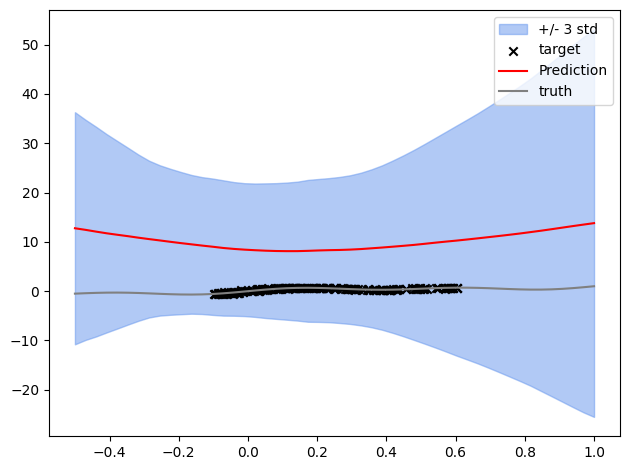

In [10]:
TEST_SAMPLES = 20

model.train()
outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, 1).to(DEVICE)
for i in range(TEST_SAMPLES):
    outputs[i] = model.forward(X_test.view(-1, INPUT_SHAPE))
outputs[TEST_SAMPLES] = model.forward(X_test.view(-1, INPUT_SHAPE))
pred_mean = outputs.mean(0).data.cpu().numpy().squeeze(1) #Compute mean prediction
pred_std = outputs.std(0).data.cpu().numpy().squeeze(1) #Compute standard deviation of prediction for each data point

#Visualization
plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                    color='cornflowerblue', alpha=.5, label='+/- 3 std')
plt.scatter(x, y,marker='x', c='black', label='target')
plt.plot(x_test, pred_mean, c='red', label='Prediction')
plt.plot(x_test, y_test, c='grey', label='truth')
plt.legend()
plt.tight_layout()

In [ ]:
# # plot a grid of `images` with `nrows` rows and `ncols` columns
# def plot_data(train_data, train_targets, test_data, test_mean, test_q25, test_q95):
#     fig = plt.figure()
#     plt.scatter(train_data, train_targets, marker='x', c='k')
#     plt.plot(test_data, test_mean, color='r')
#     xx = np.linspace(-0.2, 1.2, 200)
#     plt.plot(test_data, nonlinear_function(test_data))
#     # plt.fill_between(train_data, test_q25, test_q95, alpha=0.2, color='purple')
#     return fig

In [ ]:
# train_data, train_target = next(iter(train_loader))

# train_data = train_data.to(DEVICE)
# train_target = train_target.to(DEVICE)
# train_data = train_data.view(-1, INPUT_SHAPE)

# test_data = torch.Tensor(np.linspace(-0.2, 1.2, 100)).to(DEVICE)
# test_data = test_data.view(-1, INPUT_SHAPE)
# # test_targets = model(test_data).detach().numpy()

# with torch.no_grad():
#     test_trace = np.array([model(test_data).detach().cpu().flatten().numpy() for _ in range(1000)]).T

# quant_25, quant_95 = np.quantile(test_trace, [0.05, 0.95], axis=1)
# test_mean = test_trace.mean(1)

# train_data = train_data.cpu().detach().numpy().reshape(-1)
# train_target = train_target.cpu().detach().numpy().reshape(-1)
# test_data = test_data.cpu().detach().numpy().reshape(-1)
# fig = plot_data(train_data, train_target, test_data, test_mean, quant_25, quant_95)
# fig.show()